# Basics of Deep Learning

In [1]:
student_id = 400100962 #@param {type:"integer"}
student_name = "Parsa Hatami" #@param {type:"string"}

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook).

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# TODO: Enter the foldername in your Drive where you have saved the
# assignment files, e.g. 'DL/assignments/assignment1/'
FOLDERNAME = 'Q3-kNN'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

The dataset for this exercise is CIFAR-10. Let's first download it then we'll explore it.

In [4]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/Q3-kNN/datasets
/content/drive/My Drive/Q3-kNN


In [6]:
import os
import pytz
from datetime import datetime

# The file path
GOOGLE_DRIVE_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
pytorch_path = os.path.join(GOOGLE_DRIVE_PATH, 'k_nearest_neighbor.py')

# Get the last modified time in UTC
last_modified_time = os.path.getmtime(pytorch_path)
utc_time = datetime.utcfromtimestamp(last_modified_time)

# Define Iran's time zone
iran_tz = pytz.timezone('Asia/Tehran')

# Convert UTC time to Iran time
iran_time = pytz.utc.localize(utc_time).astimezone(iran_tz)

# Print the result in Iran's local time
print(f"k_nearest_neighbor.py last edited on: {iran_time.strftime('%Y-%m-%d %H:%M:%S')}")

k_nearest_neighbor.py last edited on: 2024-10-27 23:17:32


# k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

You will implement these steps in this notebook and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

The following code is to setup the enviroment

In [7]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is here so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [8]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [9]:
################################################################################
# TODO:                                                                        #
# As a sanity check, print out the size of the training and test data and      #
# also the size of their labels                                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


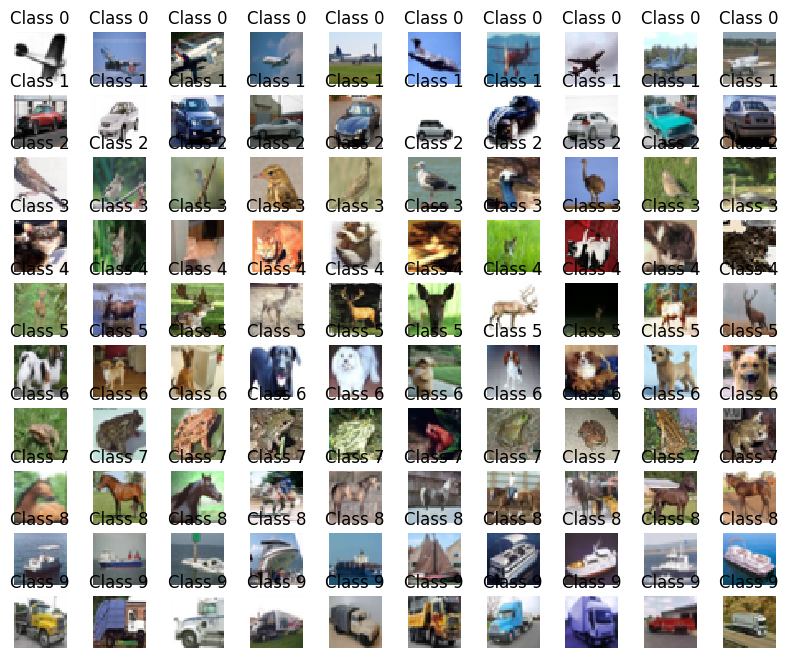

In [10]:
classes = []
num_classes = None
samples_per_class = 10

################################################################################
# TODO:                                                                        #
# Explore the dataset and find its classes. Then visualize some examples.      #
# To do so show a few examples of training images from each class              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

classes = np.unique(y_train)
num_classes = len(classes)

# Plotting some examples of training images for each class
for cls in classes:
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(num_classes, samples_per_class, i + cls * samples_per_class + 1)

        # Scale the image to [0, 1] if needed
        img = X_train[idx]
        if img.max() > 1:  # if data is in [0, 255], normalize to [0, 1]
            img = img / 255.0

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Class {cls}")

plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [11]:
################################################################################
# TODO:                                                                        #
# Subsample the data for more efficient code execution in this exercise.       #
# You should reduce the number of training and test examples used.             #
# Set num_training to 5000 and num_test to 500.                                #
# Reshape the image data into rows to prepare for processing.                  #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_training = 5000
num_test = 500

# Subsample the training data
X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Subsample the test data
X_test = X_test[:num_test]
y_test = y_test[:num_test]

# Reshape the image data into rows
X_train = X_train.reshape(num_training, -1)
X_test = X_test.reshape(num_test, -1)

# Print the new shapes as a sanity check
print("Subsampled training data shape:", X_train.shape)
print("Subsampled test data shape:", X_test.shape)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Subsampled training data shape: (5000, 3072)
Subsampled test data shape: (500, 3072)


In [12]:
from k_nearest_neighbor import KNearestNeighbor

################################################################################
# TODO:                                                                        #
# Create a kNN classifier instance and call its training method.                #
# Remember that training a kNN classifier is a noop:                           #
# the classifier simply remembers the data and does no further processing.     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

knn = KNearestNeighbor()

knn.train(X_train, y_train)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [13]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# TODO: Test your implementation:
dists = knn.compute_distances_two_loops(X_test)

print(dists.shape)

(500, 5000)


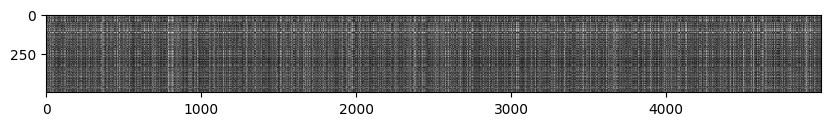

In [14]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{pink}{\textit{Your Answer:}}$

- **Bright Rows**: The bright rows in the distance matrix represent test images that have generally high distances from all training images. This occurs when certain test images have features that are not well-represented in the training data, making them appear as outliers. In other words, these test examples might belong to categories, styles, or orientations that are significantly different from most of the training examples. This lack of similarity results in uniformly high distances across the row, indicating that no training example is a close match. Bright rows can highlight areas where the training dataset might lack diversity or coverage of certain features present in the test dataset, which could impact the model's ability to generalize to these unseen patterns.

- **Bright Columns**: The bright columns indicate training images that are far from all test images. This can happen if certain training examples contain unique or uncommon features, making them dissimilar to most test examples. These training images may represent rare or unusual patterns, backgrounds, colors, or distortions that do not appear in the test set. Consistently high distances across a column suggest that these training examples do not have comparable test examples, which could imply that these training examples might not be contributing effectively to the classification task. Such cases might also indicate outliers in the training data that could potentially be removed or need further analysis.

- **Structured Patterns**: The structured patterns in the distance matrix (where rows and columns alternate between high and low distances) reflect clusters within the dataset. When certain groups of test images share similarities, they tend to have lower distances to particular groups of training images, creating darker blocks within the matrix. This structure indicates that the dataset has certain subgroups or clusters of similar images, likely corresponding to different classes or common features within classes. The alternating high and low distances showcase how well-represented each test image is across various training samples, giving insights into the alignment between test and training distributions.

Bright rows and columns in the distance matrix reveal potential gaps in feature coverage between the training and test datasets. Bright rows suggest test examples that are not well-represented in the training data, while bright columns suggest training examples that do not match any test data. The structured patterns highlight the clustering and representativeness of the data, which is essential for understanding how well the kNN classifier might perform in capturing similarities across classes.


In [18]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = knn.predict_labels(dists, k=1)

# TODO: Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
num_test = y_test.shape[0]
accuracy = num_correct / num_test
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

137 / 500 were correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [19]:
# TODO: Do the same as before with k=5
y_test_pred = knn.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
num_test = y_test.shape[0]
accuracy = num_correct / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

139 / 500 were correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.


$\color{pink}{\textit{Your Answer:}}$

The following preprocessing steps will **not change** the performance of a Nearest Neighbor classifier that uses L1 distance:
- **1. Subtracting the mean** $\mu$ ($\tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu$)
- **2. Subtracting the per pixel mean** $\mu_{ij}$ ($\tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu_{ij}$)

$\color{pink}{\textit{Your Explanation:}}$

1. **Subtracting the mean $\mu$**:
   - Subtracting a global mean $\mu$ shifts all pixel values by a constant amount. For each pixel $p_{ij}^{(k)}$ in image $I_k$, the transformed pixel value becomes $\tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu$.
   - When computing the L1 distance between two images $I_a$ and $I_b$, we get:
     $$d_{L1}(I_a, I_b) = \sum_{i,j} \left| \tilde{p}_{ij}^{(a)} - \tilde{p}_{ij}^{(b)} \right| = \sum_{i,j} \left| (p_{ij}^{(a)} - \mu) - (p_{ij}^{(b)} - \mu) \right|$$
   - Simplifying, we have:
     $$d_{L1}(I_a, I_b) = \sum_{i,j} \left| p_{ij}^{(a)} - p_{ij}^{(b)} \right|$$
   - Since the mean value $\mu$ cancels out, the L1 distance remains unchanged. Thus, this preprocessing step does not affect the performance of a Nearest Neighbor classifier with L1 distance.

2. **Subtracting the per-pixel mean $\mu_{ij}$**:
   - Subtracting the per-pixel mean $\mu_{ij}$ adjusts each pixel location $(i,j)$ by the average pixel value across all images at that location. For each pixel $p_{ij}^{(k)}$, the transformed pixel value becomes $\tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu_{ij}$.
   - When calculating the L1 distance between two images $I_a$ and $I_b$:
     $$d_{L1}(I_a, I_b) = \sum_{i,j} \left| \tilde{p}_{ij}^{(a)} - \tilde{p}_{ij}^{(b)} \right| = \sum_{i,j} \left| (p_{ij}^{(a)} - \mu_{ij}) - (p_{ij}^{(b)} - \mu_{ij}) \right|$$
   - This simplifies to:
     $$d_{L1}(I_a, I_b) = \sum_{i,j} \left| p_{ij}^{(a)} - p_{ij}^{(b)} \right|$$
   - Similar to the global mean subtraction, the per-pixel mean $\mu_{ij}$ cancels out, leaving the L1 distance unchanged. Therefore, this transformation does not impact the classifier’s performance with L1 distance.

3. **Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$**:
   - This transformation, $\tilde{p}_{ij}^{(k)} = \frac{p_{ij}^{(k)} - \mu}{\sigma}$, normalizes pixel values by both centering and scaling them. When we compute the L1 distance between two images $I_a$ and $I_b$:
     $$d_{L1}(I_a, I_b) = \sum_{i,j} \left| \frac{p_{ij}^{(a)} - \mu}{\sigma} - \frac{p_{ij}^{(b)} - \mu}{\sigma} \right|$$
   - This simplifies to:
     $$d_{L1}(I_a, I_b) = \frac{1}{\sigma} \sum_{i,j} \left| p_{ij}^{(a)} - p_{ij}^{(b)} \right|$$
   - The division by $\sigma$ scales the L1 distance by a factor of $\frac{1}{\sigma}$, which changes the absolute distance values. This scaling would affect the performance of a Nearest Neighbor classifier since the relative distances may change, potentially altering the nearest neighbors.

4. **Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$**:
   - This transformation, $\tilde{p}_{ij}^{(k)} = \frac{p_{ij}^{(k)} - \mu_{ij}}{\sigma_{ij}}$, normalizes each pixel individually across all images. When computing the L1 distance:
     $$d_{L1}(I_a, I_b) = \sum_{i,j} \left| \frac{p_{ij}^{(a)} - \mu_{ij}}{\sigma_{ij}} - \frac{p_{ij}^{(b)} - \mu_{ij}}{\sigma_{ij}} \right|$$
   - This cannot be simplified in a way that cancels out the $\sigma_{ij}$ terms. As a result, each pixel will be scaled individually, altering the relative distances in a non-uniform way. This transformation would therefore impact the classifier’s performance with L1 distance.

5. **Rotating the coordinate axes**:
   - Rotating all images affects the spatial arrangement of pixel values. L1 distance depends on comparing corresponding pixel values across images, so rotating images will likely increase distances due to mismatched pixel positions.
   - Additionally, rotating introduces padding, which further alters pixel values and disrupts the original spatial relationships. Consequently, this preprocessing step would change the L1 distances and affect the Nearest Neighbor classifier’s performance.

In summary:
- **Steps 1 and 2** do not affect the L1 distance because they involve only mean subtraction, which cancels out when computing distances.
- **Steps 3, 4, and 5** alter the L1 distance by scaling or changing spatial arrangements, thus impacting the classifier’s performance.




In [20]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = knn.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [21]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = knn.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


Explain how you have implemented compute_distances_no_loops

Explain how you have implemented compute_distances_no_loops

$\color{pink}{\textit{Your Answer:}}$

In the `compute_distances_no_loops` function, I implemented a fully vectorized approach to calculate the Euclidean distances between each test point and each training point without using any explicit loops. The idea is to use matrix operations to achieve this efficiently.

To compute the L2 distance between two vectors $x$ and $y$, we can use the formula:
$$
\text{distance}(x, y) = \sqrt{\sum (x - y)^2} = \sqrt{x^2 + y^2 - 2 \cdot x \cdot y}
$$

Given that we have matrices $X$ for test points (of shape $\text{num\_test} \times D$) and $\text{self.X\_train}$ for training points (of shape $\text{num\_train} \times D$), I broke down the computation as follows:

1. **Compute the squared terms**:
   - First, I computed the squared values of each element in both $X$ and $\text{self.X\_train}$.
   - The term $X_{\text{squared}}$ contains the sum of squares for each test point, with shape $(\text{num\_test}, 1)$:
     $$
     X_{\text{squared}} = \sum X^2 \text{ along the last dimension}
     $$
   - Similarly, $\text{train\_squared}$ contains the sum of squares for each training point, with shape $(1, \text{num\_train})$:
     $$
     \text{train\_squared} = \sum \text{self.X\_train}^2 \text{ along the last dimension}
     $$

2. **Compute the cross-term**:
   - To get the term that corresponds to $-2 \cdot x \cdot y$ for each pair of test and training points, I used a matrix multiplication of $X$ and $\text{self.X\_train}^T$. This results in a matrix $\text{cross\_term}$ of shape $(\text{num\_test}, \text{num\_train})$, where each entry represents the dot product between a test and a training point:
     $$
     \text{cross\_term} = X \cdot \text{self.X\_train}^T
     $$

3. **Combine terms to get distances**:
   - With $X_{\text{squared}}$, $\text{train\_squared}$, and $\text{cross\_term}$ ready, I used the following formula to get the squared Euclidean distance matrix:
     $$
     \text{dists\_squared} = X_{\text{squared}} + \text{train\_squared} - 2 \cdot \text{cross\_term}
     $$
   - Finally, I took the square root of each element in $\text{dists\_squared}$ to get the final distance matrix $\text{dists}$:
     $$
     \text{dists} = \sqrt{\text{dists\_squared}}
     $$

This fully vectorized approach efficiently computes the distance matrix without any explicit loops, leveraging matrix operations for speed. By avoiding loops, this implementation is much faster, especially when handling large datasets.



In [22]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(knn.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(knn.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(knn.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 33.782830 seconds
One loop version took 35.119862 seconds
No loop version took 0.493440 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [23]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    # Initialize an empty list to store accuracies for the current value of k
    k_to_accuracies[k] = []

    # Perform cross-validation
    for i in range(num_folds):
        # Use fold i as the validation set, and the rest as the training set
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]

        # Combine the other folds to form the training set
        X_train_fold = np.concatenate([X_train_folds[j] for j in range(num_folds) if j != i])
        y_train_fold = np.concatenate([y_train_folds[j] for j in range(num_folds) if j != i])

        # Train the k-NN classifier
        knn = KNearestNeighbor()
        knn.train(X_train_fold, y_train_fold)

        # Predict on the validation fold
        dists = knn.compute_distances_no_loops(X_val_fold)
        y_val_pred = knn.predict_labels(dists, k)

        # Calculate the accuracy and store it
        accuracy = np.mean(y_val_pred == y_val_fold)
        k_to_accuracies[k].append(accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

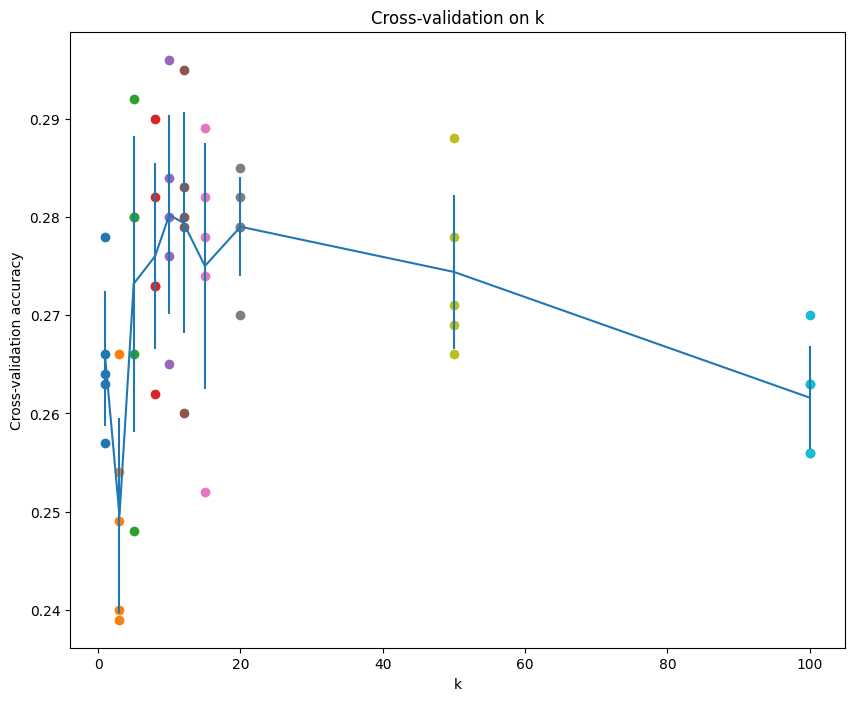

In [24]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [25]:
# TODO: Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = max(k_to_accuracies, key=lambda k: np.mean(k_to_accuracies[k]))

knn = KNearestNeighbor()
knn.train(X_train, y_train)

dists = knn.compute_distances_no_loops(X_test)
y_test_pred = knn.predict_labels(dists, best_k)

num_correct = np.sum(y_test_pred == y_test)
num_test = y_test.shape[0]
accuracy = num_correct / num_test

print('Best k chosen from cross-validation: %d' % best_k)
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

Best k chosen from cross-validation: 10
141 / 500 were correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{pink}{\textit{Your Answer:}}$  
Statements **2** and **4** are true.

$\color{pink}{\textit{Your Explanation:}}$

1. **The decision boundary of the k-NN classifier is linear**:  
   This statement is **false**. The decision boundary of a k-NN classifier is generally non-linear, as it is determined by the distribution of the training data rather than by any linear function. The boundary can become highly irregular, especially for smaller values of \( k \), as it adapts to the shape of the data distribution.

2. **The training error of a 1-NN will always be lower than or equal to that of 5-NN**:  
   This statement is **true**. In a 1-NN classifier, each training example is classified based on its nearest neighbor, which will always be itself. This results in a training error of zero (assuming no duplicates with different labels in the training set). For 5-NN, the classifier may misclassify some training points because it considers the nearest 5 neighbors, potentially leading to higher training error. Therefore, the training error for 1-NN is generally lower than or equal to that of 5-NN.

3. **The test error of a 1-NN will always be lower than that of a 5-NN**:  
   This statement is **false**. Although 1-NN perfectly classifies the training data, it tends to overfit, which often results in higher test error on new, unseen data. 5-NN, with a higher \( k \) value, usually provides a smoother decision boundary, which can generalize better and often results in lower test error compared to 1-NN.

4. **The time needed to classify a test example with the k-NN classifier grows with the size of the training set**:  
   This statement is **true**. To classify a test example, the k-NN algorithm calculates the distance between the test example and each point in the training set. As the training set size increases, the number of distance calculations grows linearly, which increases the time needed to classify a test example.

5. **None of the above**:  
   This statement is **false** because statements **2** and **4** are correct.
   
The correct answers are **2** and **4** because they accurately describe properties of the k-NN classifier in a classification setting.

